# Data: Lake Michigan Waves

https://data.cityofchicago.org/Parks-Recreation/Beach-Water-Quality-Automated-Sensors/qmqz-2xku

Can we predict wave height based on wave period (time between waves)?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 16

In [2]:
df = pd.read_csv("waves.csv")
df.head()

,Beach Name,Measurement Timestamp,Water Temperature,Turbidity,Transducer Depth,Wave Height,Wave Period,Battery Life,Measurement Timestamp Label,Measurement ID
0,Ohio Street Beach,06/02/2019 05:00:00 PM,17.1,0.78,NaN,0.232,4.0,10.9,06/02/2019 5:00 PM,OhioStreetBeach201906021700
1,63rd Street Beach,09/18/2013 10:00:00 AM,18.9,7.56,1.517,0.140,4.0,11.0,09/18/2013 10:00 AM,63rdStreetBeach201309181000
2,63rd Street Beach,06/12/2014 12:00:00 PM,25.4,3.45,-0.072,0.031,9.0,12.2,06/12/2014 12:00 PM,63rdStreetBeach201406121200
3,63rd Street Beach,06/12/2014 01:00:00 PM,18.1,3.31,1.818,0.339,10.0,12.2,06/12/2014 1:00 PM,63rdStreetBeach201406121300
4,63rd Street Beach,06/12/2014 02:00:00 PM,17.5,2.93,1.545,0.136,4.0,12.2,06/12/2014 2:00 PM,63rdStreetBeach201406121400


<AxesSubplot:xlabel='Wave Period', ylabel='Wave Height'>

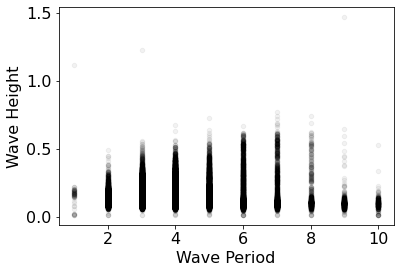

In [3]:
df = df[(df["Wave Period"] > 0) & (df["Wave Height"] > 0)]
df.plot.scatter(x="Wave Period", y="Wave Height", color="k", alpha=0.05)
# observation: non-linear relationship

In [4]:
beach_names = sorted(set(df["Beach Name"]))
beach_names

['63rd Street Beach',
 'Calumet Beach',
 'Montrose Beach',
 'Ohio Street Beach',
 'Osterman Beach',
 'Rainbow Beach']

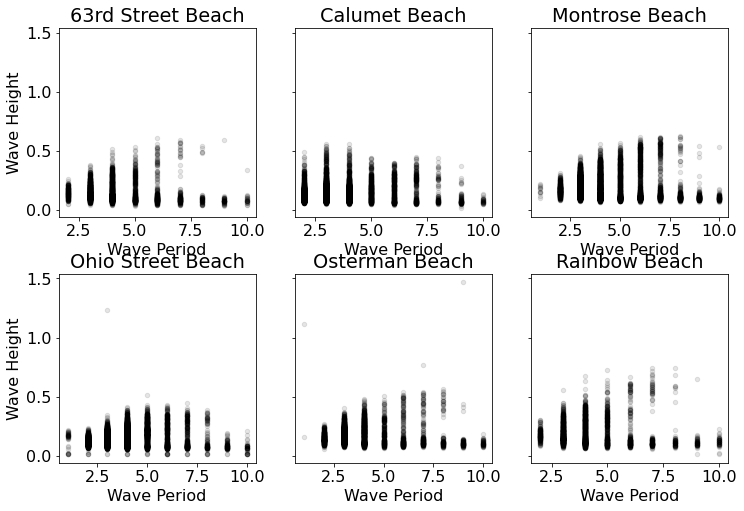

In [5]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharey=True)
plt.subplots_adjust(hspace=0.3)
axes = list(axes.reshape(-1))
for b in beach_names:
    ax = axes.pop(0)
    ax.set_title(b)
    beach_df = df[df["Beach Name"] == b]
    beach_df.plot.scatter(x="Wave Period", y="Wave Height", 
                          color="k", alpha=0.1, ax=ax)
# obversation: which beach (categorical feature) is important

# Four Models

1. wave period (linear)
2. wave period (polynomial)
3. beach
4. beach and wave period

In [6]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression

from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder

## Model 1: Wave Period (Linear)

In [7]:
train, test = train_test_split(df)
len(train), len(test)

(29037, 9679)

In [8]:
# LinReg CAN do this:
# y = x1*3 + x2*4
# IT CANNOT do this:
# Y = x*3 + x**2*4
# TRICK: set x2=x1**2

m1 = LinearRegression()
m1.fit(train[["Wave Period"]], train["Wave Height"])
m1.score(test[["Wave Period"]], test["Wave Height"])

0.001562743112582976

In [9]:
scores = cross_val_score(m1, train[["Wave Period"]], train["Wave Height"], cv=10)
scores.mean()

0.0014646658503434163

## Model 2: Wave Period (Polynomial)

In [10]:
demo = train[["Wave Period"]].copy()
demo["Wave Period ^ 2"] = demo["Wave Period"] ** 2
demo["Wave Period ^ 3"] = demo["Wave Period"] ** 3
demo.head()

,Wave Period,Wave Period ^ 2,Wave Period ^ 3
21396,6.0,36.0,216.0
5670,2.0,4.0,8.0
28408,3.0,9.0,27.0
13805,4.0,16.0,64.0
32575,4.0,16.0,64.0


In [11]:
pf = PolynomialFeatures(degree=3, include_bias=False)
data = pf.fit_transform(train[["Wave Period"]])
data

array([[  6.,  36., 216.],
       [  2.,   4.,   8.],
       [  3.,   9.,  27.],
       ...,
       [  6.,  36., 216.],
       [  3.,   9.,  27.],
       [  4.,  16.,  64.]])

In [12]:
pf.get_feature_names_out()

array(['Wave Period', 'Wave Period^2', 'Wave Period^3'], dtype=object)

In [13]:
pd.DataFrame(data, columns=pf.get_feature_names_out())

,Wave Period,Wave Period^2,Wave Period^3
0,6.0,36.0,216.0
1,2.0,4.0,8.0
2,3.0,9.0,27.0
3,4.0,16.0,64.0
4,4.0,16.0,64.0
...,...,...,...
29032,3.0,9.0,27.0
29033,2.0,4.0,8.0
29034,6.0,36.0,216.0
29035,3.0,9.0,27.0


In [14]:
# PIPELINES
# m2 = Pipeline([
#     TRANSFORM1
#     ...
#     TRANSFORM-N
#     ESTIMATOR
# ])

In [17]:
m2 = Pipeline([
    ("poly", PolynomialFeatures(degree=3, include_bias=False)),
    ("lr", LinearRegression())
])

m2.fit(train[["Wave Period"]], train["Wave Height"])
m2.score(test[["Wave Period"]], test["Wave Height"])

0.05408100268655469

In [18]:
test["Wave Height"].var() # how much of this do we explain?  (score)

0.007214784204286379

## Model 3: Beach Name (Categorical)

In [ ]:
# need to somehow convert category (like beach) to numbers
# Ohio => 1
# Calumet => 2
# Rainbow => 3
# PROBLEM: the models thinks Calumet behaves like the average of Ohio and Rainbow

In [20]:
train.head()

,Beach Name,Measurement Timestamp,Water Temperature,Turbidity,Transducer Depth,Wave Height,Wave Period,Battery Life,Measurement Timestamp Label,Measurement ID
21396,Ohio Street Beach,08/02/2015 02:00:00 AM,22.8,0.50,NaN,0.089,6.0,11.6,08/02/2015 2:00 AM,OhioStreetBeach201508020200
5670,Calumet Beach,05/24/2015 12:00:00 AM,14.5,1.53,NaN,0.135,2.0,11.4,05/24/2015 12:00 AM,CalumetBeach201505242400
28408,Osterman Beach,07/17/2014 08:00:00 PM,19.6,0.63,1.405,0.207,3.0,11.8,07/17/2014 8:00 PM,OstermanBeach201407172000
13805,Montrose Beach,06/15/2015 08:00:00 AM,15.6,0.52,NaN,0.068,4.0,10.5,06/15/2015 8:00 AM,MontroseBeach201506150800
32575,Rainbow Beach,06/12/2015 05:00:00 AM,16.2,2.96,NaN,0.251,4.0,12.6,06/12/2015 5:00 AM,RainbowBeach201506120500


In [23]:
oh = OneHotEncoder()
data = oh.fit_transform(train[["Beach Name"]])
data

<29037x6 sparse matrix of type '<class 'numpy.float64'>'
	with 29037 stored elements in Compressed Sparse Row format>

In [26]:
oh.get_feature_names_out()

array(['Beach Name_63rd Street Beach', 'Beach Name_Calumet Beach',
       'Beach Name_Montrose Beach', 'Beach Name_Ohio Street Beach',
       'Beach Name_Osterman Beach', 'Beach Name_Rainbow Beach'],
      dtype=object)

In [28]:
pd.DataFrame(data.toarray(), columns=oh.get_feature_names_out()).head()

,Beach Name_63rd Street Beach,Beach Name_Calumet Beach,Beach Name_Montrose Beach,Beach Name_Ohio Street Beach,Beach Name_Osterman Beach,Beach Name_Rainbow Beach
0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0


In [29]:
m3 = Pipeline([
    ("onehot", OneHotEncoder()),
    ("lr", LinearRegression()),
])
m3

Pipeline(steps=[('onehot', OneHotEncoder()), ('lr', LinearRegression())])

In [30]:
m3.fit(train[["Beach Name"]], train["Wave Height"])
m3.score(test[["Beach Name"]], test["Wave Height"])

0.053744498747366976

## Model 4: Beach Name and Wave Period (Polynomial)

In [ ]:
# combined = make_column_transformer(
#     (TRANSFORMER1, [COLUMNS]),
#     (TRANSFORMER2, [COLUMNS]),
# )

In [48]:
combined = make_column_transformer(
    (PolynomialFeatures(degree=3, include_bias=False), ["Wave Period"]),
    (OneHotEncoder(), ["Beach Name"]),
)

In [55]:
data = combined.fit_transform(train[["Wave Period", "Beach Name"]])
pd.DataFrame(data, columns=combined.get_feature_names_out()).head(3)

,polynomialfeatures__Wave Period,polynomialfeatures__Wave Period^2,polynomialfeatures__Wave Period^3,onehotencoder__Beach Name_63rd Street Beach,onehotencoder__Beach Name_Calumet Beach,onehotencoder__Beach Name_Montrose Beach,onehotencoder__Beach Name_Ohio Street Beach,onehotencoder__Beach Name_Osterman Beach,onehotencoder__Beach Name_Rainbow Beach
0,6.0,36.0,216.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2.0,4.0,8.0,0.0,1.0,0.0,0.0,0.0,0.0
2,3.0,9.0,27.0,0.0,0.0,0.0,0.0,1.0,0.0


In [49]:
m4 = Pipeline([
    ("transformer", combined),
    ("lr", LinearRegression()),
])
m4

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('polynomialfeatures',
                                                  PolynomialFeatures(degree=3,
                                                                     include_bias=False),
                                                  ['Wave Period']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['Beach Name'])])),
                ('lr', LinearRegression())])

In [50]:
m4.fit(train[["Wave Period", "Beach Name"]], train["Wave Height"])
m4.score(test[["Wave Period", "Beach Name"]], test["Wave Height"])

0.10153050900287375

In [56]:
# a pipeline is like a dictionary of stages

In [57]:
m4["transformer"]

ColumnTransformer(transformers=[('polynomialfeatures',
                                 PolynomialFeatures(degree=3,
                                                    include_bias=False),
                                 ['Wave Period']),
                                ('onehotencoder', OneHotEncoder(),
                                 ['Beach Name'])])

In [58]:
data = m4["transformer"].fit_transform(train[["Wave Period", "Beach Name"]])
pd.DataFrame(data, columns=m4["transformer"].get_feature_names_out()).head(3)

,polynomialfeatures__Wave Period,polynomialfeatures__Wave Period^2,polynomialfeatures__Wave Period^3,onehotencoder__Beach Name_63rd Street Beach,onehotencoder__Beach Name_Calumet Beach,onehotencoder__Beach Name_Montrose Beach,onehotencoder__Beach Name_Ohio Street Beach,onehotencoder__Beach Name_Osterman Beach,onehotencoder__Beach Name_Rainbow Beach
0,6.0,36.0,216.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2.0,4.0,8.0,0.0,1.0,0.0,0.0,0.0,0.0
2,3.0,9.0,27.0,0.0,0.0,0.0,0.0,1.0,0.0


In [60]:
m4["lr"].coef_

array([ 0.03545138, -0.00212612, -0.00015751, -0.02459595, -0.01961572,
        0.0241625 , -0.01385944,  0.0086844 ,  0.02522421])

In [63]:
# how does the m4 model make predictions?
cols = m4["transformer"].get_feature_names_out()
cols = [c.split("_")[-1] for c in cols]
cols

['Wave Period',
 'Wave Period^2',
 'Wave Period^3',
 '63rd Street Beach',
 'Calumet Beach',
 'Montrose Beach',
 'Ohio Street Beach',
 'Osterman Beach',
 'Rainbow Beach']

<AxesSubplot:>

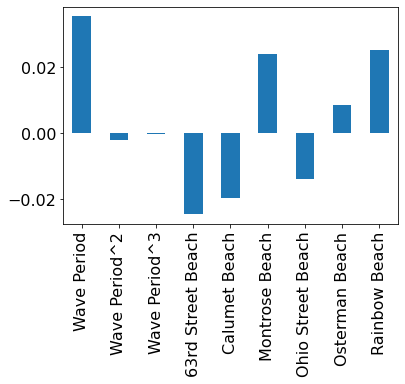

In [65]:
pd.Series(m4["lr"].coef_, index=cols).plot.bar()